# Projet Lichess

_Traitements et données large échelle_

Zoé Marquis & Charlotte Kruzic

TODO : présenter les objectifs du projet, les différentes questions, les données utilisées


## Installation et importation des bibliothèques nécessaires

In [1]:
!pip install kagglehub

In [2]:
!pip install -q findspark

In [3]:
!pip install pyspark

In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import kagglehub

import findspark
from pyspark.sql import SparkSession

In [5]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz

In [6]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

## Préparation des données et de l'environnement

Chargement des données, analyse exploratoire et prétraitement des données.

### Chargement du fichier de données

In [7]:
path = kagglehub.dataset_download("noobiedatascientist/lichess-september-2020-data")
print("Chemin vers le fichier du dataset : ", path)

100%|██████████| 324M/324M [00:06<00:00, 54.0MB/s]

Extracting files...


Chemin vers le fichier du dataset :  /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3


In [8]:
files = os.listdir(path)
print("Fichiers du dataset : ", files)

Fichiers du dataset :  ['Sept_20_analysis.RDS', 'Sept_20_analysis.csv', 'Column information.txt']


In [9]:
filename = f"{path}/Sept_20_analysis.csv"
print("Nom du fichier : ", filename)

Nom du fichier :  /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3/Sept_20_analysis.csv


In [10]:
# voir le contenu du .txt
filename_txt = f"{path}/Column information.txt"
with open(filename_txt, 'r') as f:
    print(f.read())

GAME: Game ID (not from lichess.org)

BlackElo: Elo rating of the player with the black pieces

BlackRatingDiff: Rating change (gain/loss) after game conclusion for the player with the black pieces

Date: Date the game was played

ECO: Game opening (ECO notation)

Event: Event where the game was played

Opening: Game opening

Result: Result of the game

	1-0 -- White victory
	0-1 -- Black victory
	1/2-1/2 -- Draw
	* -- Undecided
	
Site: URL of the game

Termination: Way the game terminated

	Time forfeit -- One of the players ran out of time
	Normal -- Game terminated with check mate
	Rules infraction -- Game terminated due to rule breaking
	Abandoned -- Game was abandoned
	
TimeControl: Timecontrol in seconds that was used for the game (Starting time: Increment) 

UTCTime: Time the game was played

WhiteElo: Elo rating of the player with the white pieces

WhiteRatingDiff: Rating change (gain/loss) after game conclusion for the player with the white pieces

Black_elo_category: ELO cate

### Lancement de Spark

In [11]:
# Importation des éléments Spark
from pyspark.sql.functions import col, when, isnull, floor, count, min as spark_min, max as spark_max, countDistinct, row_number, split, concat_ws, sum as spark_sum, rank
from pyspark.sql.window import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from collections import defaultdict

In [12]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [13]:
sc = spark.sparkContext
df_spark = spark.read.csv(filename, header=True, inferSchema=True)

In [14]:
df_spark.printSchema()

root
 |-- GAME: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- BlackRatingDiff: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- Site: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Black_elo_category: string (nullable = true)
 |-- White_elo_category: string (nullable = true)
 |-- starting_time: integer (nullable = true)
 |-- increment: integer (nullable = true)
 |-- Game_type: string (nullable = true)
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistak

In [15]:
# nombre lignes
df_spark.count()

3739909

In [16]:
df_spark.show(5)

+----+--------+---------------+----------+---+----------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|           Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_

### Préparation générale des données

Maintenant que les données sont chargées, nous y ajoutons les catégories ELO basées sur les plages données dans l'énoncé du projet.

En plus des 5 catégories définies dans l'énoncé, nous ajoutons "other lower bound" et "other upper bound" pour les valeurs ELO hors des plages.

#### Calcule des catégories ELO

In [17]:
# Ajout des catégories ELO
# Catégorie ELO du joueur Noir
df_spark_plus = df_spark.withColumn("Black_ELO_category",
                              when((col("BlackElo") >= 1200) & (col("BlackElo") <= 1499), "occasional player")
                              .when((col("BlackElo") >= 1500) & (col("BlackElo") <= 1799), "good club player")
                              .when((col("BlackElo") >= 1800) & (col("BlackElo") <= 1999), "very good club player")
                              .when((col("BlackElo") >= 2000) & (col("BlackElo") <= 2399), "national and international level")
                              .when((col("BlackElo") >= 2400) & (col("BlackElo") <= 2800), "GMI, World Champions")
                              .when((col("BlackElo") < 1200), "other lower bound")
                              .otherwise("other upper bound")
                              )

# Catégorie ELO du joueur Blanc
df_spark_plus = df_spark_plus.withColumn("White_ELO_category",
                              when((col("WhiteElo") >= 1200) & (col("WhiteElo") <= 1499), "occasional player")
                              .when((col("WhiteElo") >= 1500) & (col("WhiteElo") <= 1799), "good club player")
                              .when((col("WhiteElo") >= 1800) & (col("WhiteElo") <= 1999), "very good club player")
                              .when((col("WhiteElo") >= 2000) & (col("WhiteElo") <= 2399), "national and international level")
                              .when((col("WhiteElo") >= 2400) & (col("WhiteElo") <= 2800), "GMI, World Champions")
                              .when((col("WhiteElo") < 1200), "other lower bound")
                              .otherwise("other upper bound")
                              )

# Catégorie ELO moyenne des 2 joueurs
df_spark_plus = df_spark_plus.withColumn("Avg_ELO_category", (col("BlackElo") + col("WhiteElo")) / 2)

df_spark_plus = df_spark_plus.withColumn("Avg_ELO_category",
                              when((col("Avg_ELO_category") >= 1200) & (col("Avg_ELO_category") <= 1499), "occasional player")
                              .when((col("Avg_ELO_category") >= 1500) & (col("Avg_ELO_category") <= 1799), "good club player")
                              .when((col("Avg_ELO_category") >= 1800) & (col("Avg_ELO_category") <= 1999), "very good club player")
                              .when((col("Avg_ELO_category") >= 2000) & (col("Avg_ELO_category") <= 2399), "national and international level")
                              .when((col("Avg_ELO_category") >= 2400) & (col("Avg_ELO_category") <= 2800), "GMI, World Champions")
                              .when((col("Avg_ELO_category") < 1200), "other lower bound")
                              .otherwise("other upper bound")
                              )

In [18]:
# vérifier combien de "other ..."
other_lower_bound_black = df_spark_plus.filter(col("Black_ELO_category") == "other lower bound").count()
other_lower_bound_white = df_spark_plus.filter(col("White_ELO_category") == "other lower bound").count()
other_upper_bound_black = df_spark_plus.filter(col("Black_ELO_category") == "other upper bound").count()
other_upper_bound_white = df_spark_plus.filter(col("White_ELO_category") == "other upper bound").count()
print(f"Nombre de parties avec other lower bound pour le joueur noir : {other_lower_bound_black}")
print(f"Nombre de parties avec other lower bound pour le joueur blanc : {other_lower_bound_white}")
print(f"Nombre de parties avec other upper bound pour le joueur noir : {other_upper_bound_black}")
print(f"Nombre de parties avec other upper bound pour le joueur blanc : {other_upper_bound_white}")

Nombre de parties avec other lower bound pour le joueur noir : 474566
Nombre de parties avec other lower bound pour le joueur blanc : 477997
Nombre de parties avec other upper bound pour le joueur noir : 1730
Nombre de parties avec other upper bound pour le joueur blanc : 1721


In [19]:
# répartition du nombre de parties pour avg
avg_other_lower_bound = df_spark_plus.filter(col("Avg_ELO_category") == "other lower bound").count()
avg_occasional_player = df_spark_plus.filter(col("Avg_ELO_category") == "occasional player").count()
avg_good_club_player = df_spark_plus.filter(col("Avg_ELO_category") == "good club player").count()
avg_very_good_club_player = df_spark_plus.filter(col("Avg_ELO_category") == "very good club player").count()
avg_national_international_level = df_spark_plus.filter(col("Avg_ELO_category") == "national and international level").count()
avg_GMI_World_Champions = df_spark_plus.filter(col("Avg_ELO_category") == "GMI, World Champions").count()
avg_other_upper_bound = df_spark_plus.filter(col("Avg_ELO_category") == "other upper bound").count()

# répartition du nombre de parties quand les 2 joueurs sont dans la même catégorie
same_player_other_lower_bound = df_spark_plus.filter((col("Black_ELO_category") == "other lower bound") & (col("White_ELO_category") == "other lower bound")).count()
same_player_occasional_player = df_spark_plus.filter((col("Black_ELO_category") == "occasional player") & (col("White_ELO_category") == "occasional player")).count()
same_player_good_club_player = df_spark_plus.filter((col("Black_ELO_category") == "good club player") & (col("White_ELO_category") == "good club player")).count()
same_player_very_good_club_player = df_spark_plus.filter((col("Black_ELO_category") == "very good club player") & (col("White_ELO_category") == "very good club player")).count()
same_player_national_international_level = df_spark_plus.filter((col("Black_ELO_category") == "national and international level") & (col("White_ELO_category") == "national and international level")).count()
same_player_GMI_World_Champions = df_spark_plus.filter((col("Black_ELO_category") == "GMI, World Champions") & (col("White_ELO_category") == "GMI, World Champions")).count()
same_player_other_upper_bound = df_spark_plus.filter((col("Black_ELO_category") == "other upper bound") & (col("White_ELO_category") == "other upper bound")).count()


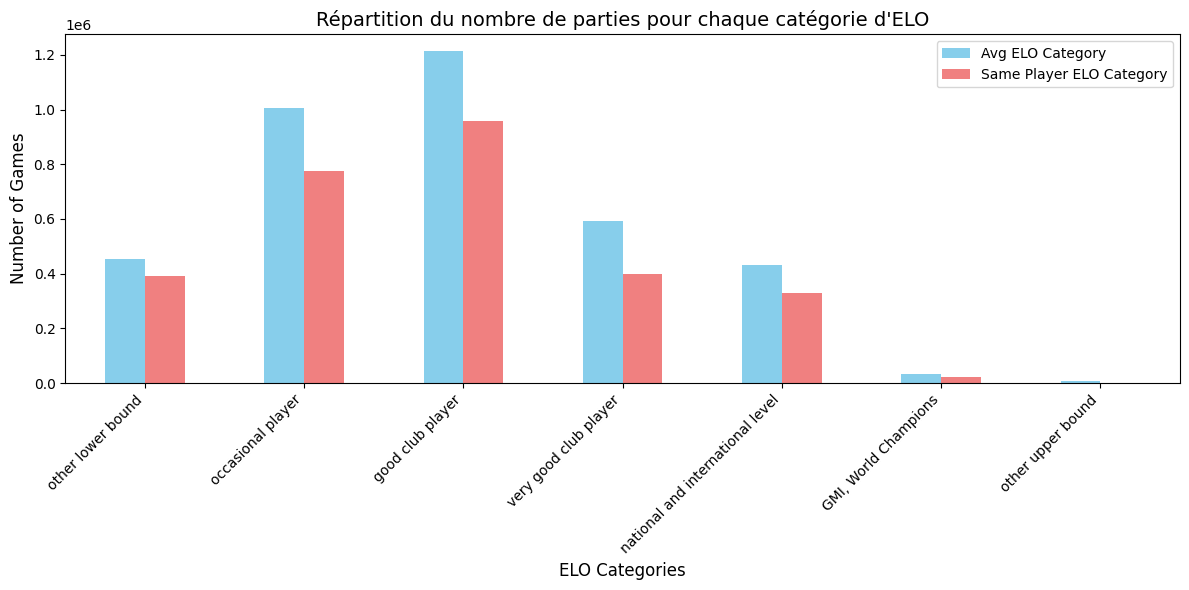

In [20]:
# Visualiser la répartition des catégories

categories = [
    "other lower bound", "occasional player", "good club player",
    "very good club player", "national and international level", "GMI, World Champions",
    "other upper bound"
]
avg_counts = [
    avg_other_lower_bound, avg_occasional_player, avg_good_club_player,
    avg_very_good_club_player, avg_national_international_level, avg_GMI_World_Champions,
    avg_other_upper_bound
]
same_player_counts = [
    same_player_other_lower_bound, same_player_occasional_player, same_player_good_club_player,
    same_player_very_good_club_player, same_player_national_international_level, same_player_GMI_World_Champions,
    same_player_other_upper_bound
]

df_counts = pd.DataFrame({
    'Category': categories,
    'Avg_ELO_category': avg_counts,
    'Same_Player_ELO_category': same_player_counts
})

plt.figure(figsize=(12, 6))
df_counts.set_index('Category')[['Avg_ELO_category', 'Same_Player_ELO_category']].plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'])
plt.xlabel('ELO Categories', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.title('Répartition du nombre de parties pour chaque catégorie d\'ELO', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(['Avg ELO Category', 'Same Player ELO Category'])
plt.tight_layout()
plt.show()

La répartition des données, bien que déséquilibrée entre les catégories, semble réaliste.

En effet, le nombre de parties avec des joueurs de niveaux intermédiaires est plus élevé, car ils représentent la plupart des joueurs actifs qui jouent régulièrement. Au contraire, le nombre de parties avec des joueurs ayant des niveaux extrêmes (faible ou élevé) est plus faible. Nous pouvons expliquer cela par le fait que les joueurs de bas niveau évoluent rapidement ou ne jouent pas beaucoup de parties, et les joueurs avec de hauts niveaux sont plus rares dû à la difficulté d'atteindre ces niveaux.

Ce déséquilibre naturel pourrait introduire un biais dans l'analyse, car certaines catégories sont sur/sous-représentées.

#### Observation du nombre de mouvements

In [21]:
# Compter le nombre de moves pour chaque joueur (c'est White qui commence)
df_spark_plus = df_spark_plus.withColumn("white_moves",
                                         when(col("Total_moves") % 2 == 0, col("Total_moves") / 2)
                                         .otherwise(floor(col("Total_moves") / 2) + 1)
                                         )
df_spark_plus = df_spark_plus.withColumn("black_moves",
                                         when(col("Total_moves") % 2 == 0, col("Total_moves") / 2)
                                         .otherwise(floor(col("Total_moves") / 2))
                                         )

In [22]:
df_spark_plus.select("Total_moves", "white_moves", "black_moves").show(5)

+-----------+-----------+-----------+
|Total_moves|white_moves|black_moves|
+-----------+-----------+-----------+
|         66|       33.0|       33.0|
|         64|       32.0|       32.0|
|         70|       35.0|       35.0|
|         86|       43.0|       43.0|
|         71|       36.0|       35.0|
+-----------+-----------+-----------+
only showing top 5 rows



#### Vérification des données

In [23]:
# TODO : Décider si on garde cette partie

##### **Valeurs NULL**

In [24]:
# Calcule valeurs null par colonnes
null_counts = df_spark.select(
    *[
        count(when(col(c).isNull(), c)).alias(c)
        for c in df_spark.columns
    ]
)

null_counts.show()

+----+--------+---------------+----+---+-----+-------+------+----+-----------+-----------+-------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|Date|ECO|Event|Opening|Result|Site|Termination|TimeControl|UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Bl

##### **Colonnes Opening et ECO**

In [25]:
# TODO : J'ai checké sur Google, et c'est connu que ECO c'est par comme Opening lol (donc je pense on vire)

Les colonnes "Opening" et "ECO" correspondent aux ouvertures et aux codes d'ouvertures, nous regardons si elles sont en liens.

In [26]:
# Nombre valeurs opening
print(f"Nombre de valeurs opening : {df_spark.select('Opening').distinct().count()}")
print(f"Nombre de valeurs ECO : {df_spark.select('ECO').distinct().count()}")

Nombre de valeurs opening : 2790
Nombre de valeurs ECO : 492


In [27]:
#  Checker si une valeur de Opening = une valeur de ECO
alignment_check_1 = df_spark.groupBy("ECO").agg(countDistinct("Opening").alias("Unique_Openings"))
misaligned_rows_1 = alignment_check_1.filter(col("Unique_Openings") > 1)

In [28]:
# Afficher les résultats
if misaligned_rows_1.count() > 0:
    print("Il existe plusieurs Openings pour un code ECO.")
    misaligned_rows_1.show(5)
    print("Nombre de lignes : ", misaligned_rows_1.count())
else:
    print("Il existe un seul Opening pour un code ECO.")

Il existe plusieurs Openings pour un code ECO.
+---+---------------+
|ECO|Unique_Openings|
+---+---------------+
|B05|              4|
|B79|              2|
|A47|              3|
|E83|              3|
|B34|              3|
+---+---------------+
only showing top 5 rows

Nombre de lignes :  353


In [29]:
#  Checker si une valeur de ECO = une valeur de Opening
alignment_check_2 = df_spark.groupBy("Opening").agg(countDistinct("ECO").alias("Unique_ECOs"))
misaligned_rows_2 = alignment_check_2.filter(col("Unique_ECOs") > 1)

In [30]:
# Afficher les résultats
if misaligned_rows_2.count() > 0:
    print("Il existe plusieurs ECO pour un code Opening.")
    misaligned_rows_2.show(5)
    print("Nombre de lignes : ", misaligned_rows_2.count())
else:
    print("Il existe un seul ECO pour un code Opening.")

Il existe plusieurs ECO pour un code Opening.
+--------------------+-----------+
|             Opening|Unique_ECOs|
+--------------------+-----------+
|  St. George Defense|          2|
|Nimzo-Indian Defe...|          5|
|        Torre Attack|          2|
|   Caro-Kann Defense|          4|
|Sicilian Defense:...|          2|
+--------------------+-----------+
only showing top 5 rows

Nombre de lignes :  95


Nous remarquons qu'un Opening peut avoir plusieurs ECO, et qu'un ECO peut également avoir plusieurs Opening.  
Nous allons regarder si c'est normal.

In [31]:
# Filtrer pour les ouvertures ayant plusieurs ECO
misaligned_rows_2 = alignment_check_2.filter(col("Unique_ECOs") > 1)
opening_eco_counts = df_spark.groupBy("Opening", "ECO").agg(count("*").alias("count"))
multiple_opening_eco_counts = misaligned_rows_2.join(opening_eco_counts, on="Opening", how="inner")
multiple_opening_eco_counts.orderBy("Opening", "count", ascending=False).show(truncate=False)


+------------------------------------------------------------------------+-----------+---+-----+
|Opening                                                                 |Unique_ECOs|ECO|count|
+------------------------------------------------------------------------+-----------+---+-----+
|Vienna Game: Vienna Gambit                                              |2          |C28|3648 |
|Vienna Game: Vienna Gambit                                              |2          |C25|1193 |
|Torre Attack                                                            |2          |A46|1704 |
|Torre Attack                                                            |2          |A48|1587 |
|St. George Defense                                                      |2          |B00|4265 |
|St. George Defense                                                      |2          |C00|690  |
|Slav Defense: Exchange Variation                                        |2          |D10|5637 |
|Slav Defense: Exchange Variat

Cela ne semble pas être des erreurs, il n'y a pas de ECO ou Opening largement dominant, nous allons donc garder ces éléments comme cela et les considérer comme 2 colonnes distinctes, n'ayant pas de lien particulier.

##### **Colonnes starting_time, increment, et TimeControl**

Nous allons maintenant vérifier si les colonnes "starting_time", "increment", et "TimeControl" sont bien en accord avec la documentation.

In [32]:
# Même nombre null pour starting_time et increment, on vérifie que c'est aligné
df_spark.filter(col("starting_time").isNull() & col("increment").isNull()).count()

10344

In [33]:
# Afficher les type de game quand ces 2 colonnes sont NULL
df_spark.filter(col("starting_time").isNull() & col("increment").isNull()).select("Game_type").distinct().show()

+--------------+
|     Game_type|
+--------------+
|Correspondence|
+--------------+



In [34]:
# Afficher les parties avec type de jeu Correspondence et starting_time ou increment non null
df_spark.filter((col("Game_type") == "Correspondence") & (col("starting_time").isNotNull() | col("increment").isNotNull())).count()

0

Cela correspond à ce qui est attendu.

Maintenant, nous vérifions que TimeControl correspond bien à `starting_time+increment`.

In [35]:
# Extraire starting_time et increment à partir de TimeControl
df_spark_check = df_spark.withColumn(
    "starting_time_extracted",
    when(col("TimeControl") != "-", split(col("TimeControl"), "\+")[0].cast("int"))
    .otherwise(None))

df_spark_check = df_spark_check.withColumn(
    "increment_extracted",
    when(col("TimeControl") != "-", split(col("TimeControl"), "\+")[1].cast("int"))
    .otherwise(None))

# Recréer TimeControl avec les colonnes extraites
df_spark_check = df_spark_check.withColumn(
    "TimeControl_reconstructed",
    when(col("starting_time_extracted").isNull() & col("increment_extracted").isNull(), "-")
    .otherwise(concat_ws("+", col("starting_time_extracted"), col("increment_extracted")))
)

# Comparer TimeControl avec la recréation
df_spark_check = df_spark_check.withColumn(
    "is_matching",
    col("TimeControl") == col("TimeControl_reconstructed")
)

# Checker les résultats
df_spark_check.select("TimeControl", "starting_time", "increment", "starting_time_extracted", "increment_extracted", "TimeControl_reconstructed", "is_matching").show(5)
mismatch_count = df_spark_check.filter(col("is_matching") == False).count()
print(f"Nombre de différences : {mismatch_count}")

+-----------+-------------+---------+-----------------------+-------------------+-------------------------+-----------+
|TimeControl|starting_time|increment|starting_time_extracted|increment_extracted|TimeControl_reconstructed|is_matching|
+-----------+-------------+---------+-----------------------+-------------------+-------------------------+-----------+
|      300+0|          300|        0|                    300|                  0|                    300+0|       true|
|      300+0|          300|        0|                    300|                  0|                    300+0|       true|
|      300+2|          300|        2|                    300|                  2|                    300+2|       true|
|      180+2|          180|        2|                    180|                  2|                    180+2|       true|
|      600+0|          600|        0|                    600|                  0|                    600+0|       true|
+-----------+-------------+---------+---

##### **Colonnes BlackRatingDiff et WhiteRatingDiff**

In [36]:
df_spark.filter(col("BlackRatingDiff").isNull() & col("WhiteRatingDiff").isNull()).count()

12968

In [37]:
# pourcentage null
prc_missed = round(df_spark.filter(col("BlackRatingDiff").isNull() | col("WhiteRatingDiff").isNull()).count()/df_spark.count()*100,2)
print(f"Pourcentage de NULL : {prc_missed}%")

Pourcentage de NULL : 0.35%


## Réponses aux questions

### Question 1

In [38]:
# TODO rregarder au global inferior moves aussi ?
# Charlotte : "si c'est un commentaire pour moi, j'ai pas compris ce que ça veut dire mdrrr"
# pov : j'écris comme le théatre

*Q1: What is the rate of blunders, errors and inaccuracies per move, per level category and on Blitz type games (Blitz type is by far the most played on these online sites). A game has two players, whose ELOs are most likely different. You will be able to classify a game into a category, either by considering the average ELO of both players, or by considering only the games where both players are in the same category.*

**Hypothèse :** Les joueurs appartenant à des catégories plus expérimentées devraient présenter un taux d'erreurs plus faible.

In [39]:
# Filtre les parties avec le type de jeu Blitz
df_blitz = df_spark_plus.filter(col("Game_type") == "Blitz")
df_blitz.count()

1812120

#### Calcule des taux par partie

In [40]:
# Calcule taux de bourdes (blunders)
df_blitz = df_blitz.withColumn("Black_blunders_rate", col("Black_blunders") / col("black_moves")) \
                   .withColumn("White_blunders_rate", col("White_blunders") / col("white_moves"))

In [41]:
# Calcule taux d'erreurs (errors)
df_blitz = df_blitz.withColumn("Black_errors_rate", col("Black_mistakes") / col("black_moves")) \
                   .withColumn("White_errors_rate", col("White_mistakes") / col("white_moves"))

In [42]:
# Calcule taux d'imprecisions (inaccurcies)
df_blitz = df_blitz.withColumn("Black_inaccuracies_rate", col("Black_inaccuracies") / col("black_moves")) \
                   .withColumn("White_inaccuracies_rate", col("White_inaccuracies") / col("white_moves"))

#### Calcule des taux moyens par catégorie ELO (on considère le score ELO moyen des 2 joueurs)

In [43]:
df_avg_elo_summary = df_blitz.groupBy("Avg_ELO_category").agg(
    {"Black_blunders_rate": "avg", "White_blunders_rate": "avg",
     "Black_errors_rate": "avg", "White_errors_rate": "avg",
     "Black_inaccuracies_rate": "avg", "White_inaccuracies_rate": "avg"}
).withColumnRenamed("avg(Black_blunders_rate)", "Avg_Black_blunders_rate") \
 .withColumnRenamed("avg(White_blunders_rate)", "Avg_White_blunders_rate") \
 .withColumnRenamed("avg(Black_errors_rate)", "Avg_Black_errors_rate") \
 .withColumnRenamed("avg(White_errors_rate)", "Avg_White_errors_rate") \
 .withColumnRenamed("avg(Black_inaccuracies_rate)", "Avg_Black_inaccuracies_rate") \
 .withColumnRenamed("avg(White_inaccuracies_rate)", "Avg_White_inaccuracies_rate")

In [44]:
df_avg_elo_summary.show(5)

+--------------------+---------------------------+-----------------------+---------------------+---------------------+-----------------------+---------------------------+
|    Avg_ELO_category|Avg_White_inaccuracies_rate|Avg_White_blunders_rate|Avg_Black_errors_rate|Avg_White_errors_rate|Avg_Black_blunders_rate|Avg_Black_inaccuracies_rate|
+--------------------+---------------------------+-----------------------+---------------------+---------------------+-----------------------+---------------------------+
|   other upper bound|        0.08923646820987065|   0.053883314861216475|  0.09786062988127485|  0.09316825168156774|    0.05713253835834972|        0.09422886449242146|
|   other lower bound|        0.09123664425761414|    0.09505881705406403|  0.11316469323850303|  0.10800044716165165|    0.09865934120262021|        0.09602531148536161|
|GMI, World Champions|        0.07247529070529041|    0.03077546627182289|  0.06824732477795835|  0.06620118207859484|    0.03325752004748459|   

In [45]:
df_avg_elo_summary_pandas = df_avg_elo_summary.toPandas()

In [46]:
df_avg_elo_summary_pandas.isna().sum()

,0
Avg_ELO_category,0
Avg_White_inaccuracies_rate,0
Avg_White_blunders_rate,0
Avg_Black_errors_rate,0
Avg_White_errors_rate,0
Avg_Black_blunders_rate,0
Avg_Black_inaccuracies_rate,0


In [47]:
# Ordonner les catégories de joueurs
category_order = ["other lower bound", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions", "other upper bound"]
df_avg_elo_summary_pandas['Avg_ELO_category'] = pd.Categorical(df_avg_elo_summary_pandas['Avg_ELO_category'],  categories=category_order,  ordered=True)
df_avg_elo_summary_pandas = df_avg_elo_summary_pandas.sort_values('Avg_ELO_category')


categories = df_avg_elo_summary_pandas['Avg_ELO_category']
error_types = ['Blunders', 'Errors', 'Inaccuracies']

# Données par type d'erreur et catégorie
blunders = df_avg_elo_summary_pandas[['Avg_Black_blunders_rate', 'Avg_White_blunders_rate']].mean(axis=1)*100
mistakes = df_avg_elo_summary_pandas[['Avg_Black_errors_rate', 'Avg_White_errors_rate']].mean(axis=1)*100
inaccuracies = df_avg_elo_summary_pandas[['Avg_Black_inaccuracies_rate', 'Avg_White_inaccuracies_rate']].mean(axis=1)*100

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

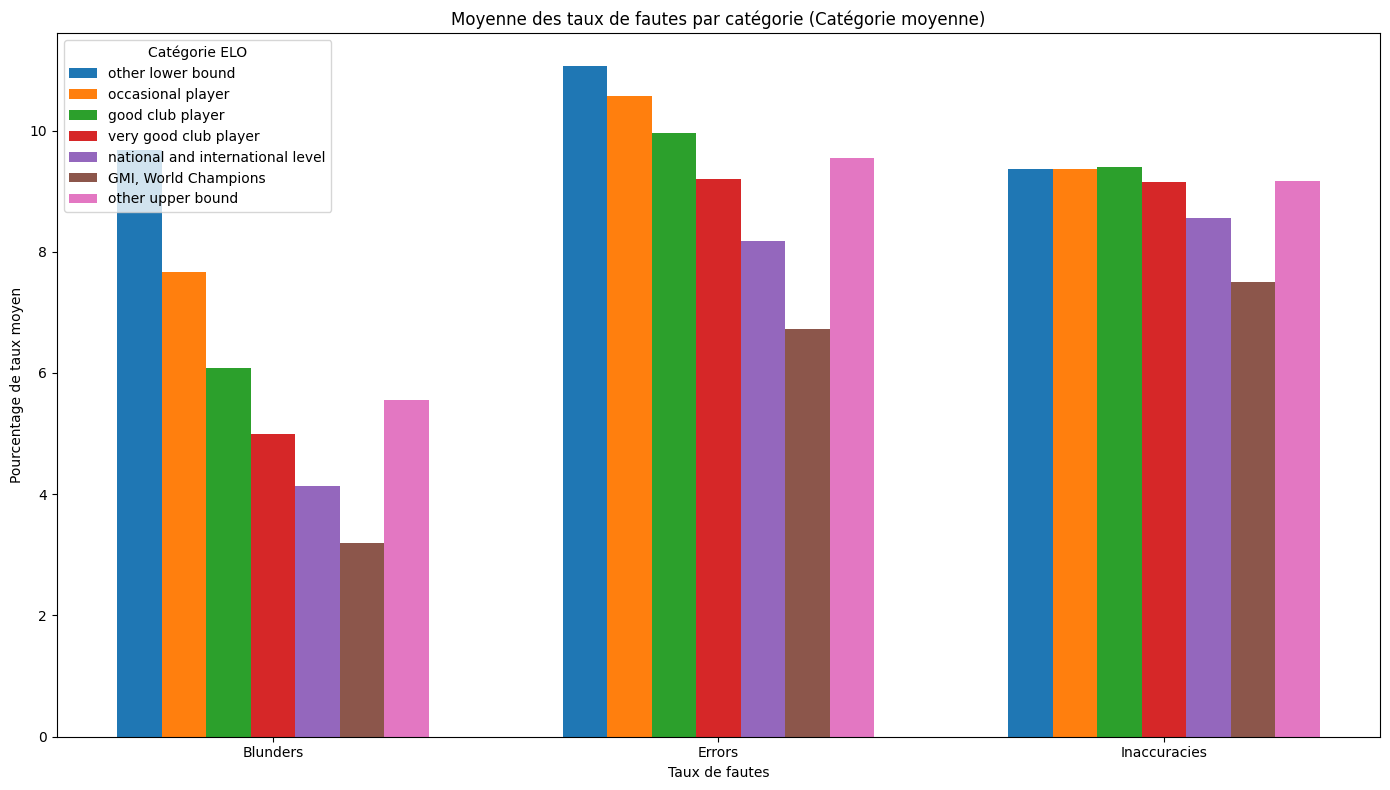

In [48]:
# Graphique
plt.figure(figsize=(14, 8))
x = np.arange(len(error_types))
bar_width = 0.1

for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=str(category))

plt.xlabel('Taux de fautes')
plt.ylabel('Pourcentage de taux moyen')
plt.title('Moyenne des taux de fautes par catégorie (Catégorie moyenne)')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, error_types)
plt.legend(title="Catégorie ELO")
plt.tight_layout()
plt.show()

##### **Analyse des taux de blunders, errors et inaccuracies selon les catégories d'ELO**

Lorsque l'on analyse les taux de blunders, errors et inaccuracies en fonction des différentes catégories ELO, plusieurs tendances intéressantes émergent.  
En excluant la catégorie "Other Upper Bound", on observe une diminution progressive des taux de **bourdes** (blunders) à mesure que les catégories augmentent, avec une chute de moins en moins marquée. Cela suggère qu'il y a une amélioration du niveau des joueurs en fonction de leur catégorie ELO, bien qu'elle soit de moins en moins évidente pour les catégories les plus expérimentées.

Concernant les taux d'**erreurs** (errors), la diminution est relativement constante à travers les catégories, mais on remarque une chute plus importante lorsque l'on atteint les deux meilleures catégories ("National and International Level" et "GMI, World Champions"). Cela indique une amélioration notable dans la gestion des erreurs pour les joueurs de niveau supérieur.

Quant aux taux d'**imprécisions** (inaccuracies), la tendance reste assez stable pour les premières catégories, avec une diminution qui s'accélère à mesure que l'on approche des deux catégories les plus élevées. Cette tendance suggère également une amélioration du jeu des joueurs plus expérimentés.

En résumé, **les taux diminuent sensiblement à mesure que l'on progresse dans les catégories ELO**, avec une amélioration plus marquée pour les catégories "National and International Level" et "GMI, World Champions", ce qui reflète probablement un meilleur contrôle stratégique et une plus grande expérience des joueurs.

##### **Analyse de la catégorie "Other Upper Bound"**

Lorsque l'on considère la catégorie "Other Upper Bound", une tendance différente se dessine.  
Les taux de blunders, errors et inaccuracies semblent augmenter pour atteindre une **valeur entre celle des catégories "Good Club Player" et "Very Good Club Player"**.

Cette anomalie pourrait suggérer plusieurs pistes d'interprétation.  
Tout d'abord, il est possible que cette catégorie contienne des **données** qui ne sont **pas représentatives** du reste des catégories en raison d'un échantillon trop faible ou non nettoyé correctement.

Une autre hypothèse pourrait être que la **performance** des joueurs dans cette catégorie est **influencée** par la moyenne des ELO des deux joueurs, et non seulement par l'ELO individuel.  
Par exemple, un joueur avec un ELO élevé qui affronte un adversaire de niveau inférieur pourrait être amené à prendre plus de risques ou adopter des stratégies différentes, ce qui expliquerait certains résultats.  
De plus, il est possible qu'une partie classée dans la catégorie "Other upper bound" n'inclue qu'un seul joueur avec un ELO très élevé, ce qui fausse la moyenne des deux scores ELO et pourrait influencer l'analyse des performances.

#### Calcule des taux moyens par catégorie ELO (ici on considère seulement les parties où les joueurs sont dans la même catégorie)


In [49]:
df_same_category = df_blitz.filter(col("Black_ELO_category") == col("White_ELO_category"))

In [50]:
tot_blitz = df_blitz.count()
tot_same_cat = df_same_category.count()
print(f"Nombre de parties total : {tot_blitz}")
print(f"Nombre de parties avec 2 joueurs de la même catégorie : {tot_blitz}")
print(f"Pourcentage même catégorie : {tot_same_cat / tot_blitz * 100} %")

Nombre de parties total : 1812120
Nombre de parties avec 2 joueurs de la même catégorie : 1812120
Pourcentage même catégorie : 77.09219036266914 %


In [51]:
# TODO : expliquer qu'on introduit un biais (comme pour le avg ducoup enfaite...)
# poru avg dire qu'on devrait un peu étudier l'écrat type peut etre ?

In [52]:
df_same_category_summary = df_same_category.groupBy("Black_ELO_category").agg(
    {"Black_blunders_rate": "avg", "White_blunders_rate": "avg",
     "Black_errors_rate": "avg", "White_errors_rate": "avg",
     "Black_inaccuracies_rate": "avg", "White_inaccuracies_rate": "avg"}
).withColumnRenamed("avg(Black_blunders_rate)", "Avg_Black_blunders_rate") \
 .withColumnRenamed("avg(White_blunders_rate)", "Avg_White_blunders_rate") \
 .withColumnRenamed("avg(Black_errors_rate)", "Avg_Black_errors_rate") \
 .withColumnRenamed("avg(White_errors_rate)", "Avg_White_errors_rate") \
 .withColumnRenamed("avg(Black_inaccuracies_rate)", "Avg_Black_inaccuracies_rate") \
 .withColumnRenamed("avg(White_inaccuracies_rate)", "Avg_White_inaccuracies_rate")

In [53]:
df_same_category_summary_pandas = df_same_category_summary.toPandas()

In [54]:
# Ordonner les catégories de joueurs
category_order = ["other lower bound", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions", "other upper bound"]
df_same_category_summary_pandas['Black_ELO_category'] = pd.Categorical(df_same_category_summary_pandas['Black_ELO_category'],  categories=category_order,  ordered=True)
df_same_category_summary_pandas = df_same_category_summary_pandas.sort_values('Black_ELO_category')


categories = df_same_category_summary_pandas['Black_ELO_category']
error_types = ['Blunders', 'Errors', 'Inaccuracies']

# Données par type d'erreur et catégorie (moyenne) # TODO : Voir si on fait autrement
blunders = df_same_category_summary_pandas[['Avg_Black_blunders_rate', 'Avg_White_blunders_rate']].mean(axis=1)*100
mistakes = df_same_category_summary_pandas[['Avg_Black_errors_rate', 'Avg_White_errors_rate']].mean(axis=1)*100
inaccuracies = df_same_category_summary_pandas[['Avg_Black_inaccuracies_rate', 'Avg_White_inaccuracies_rate']].mean(axis=1)*100

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

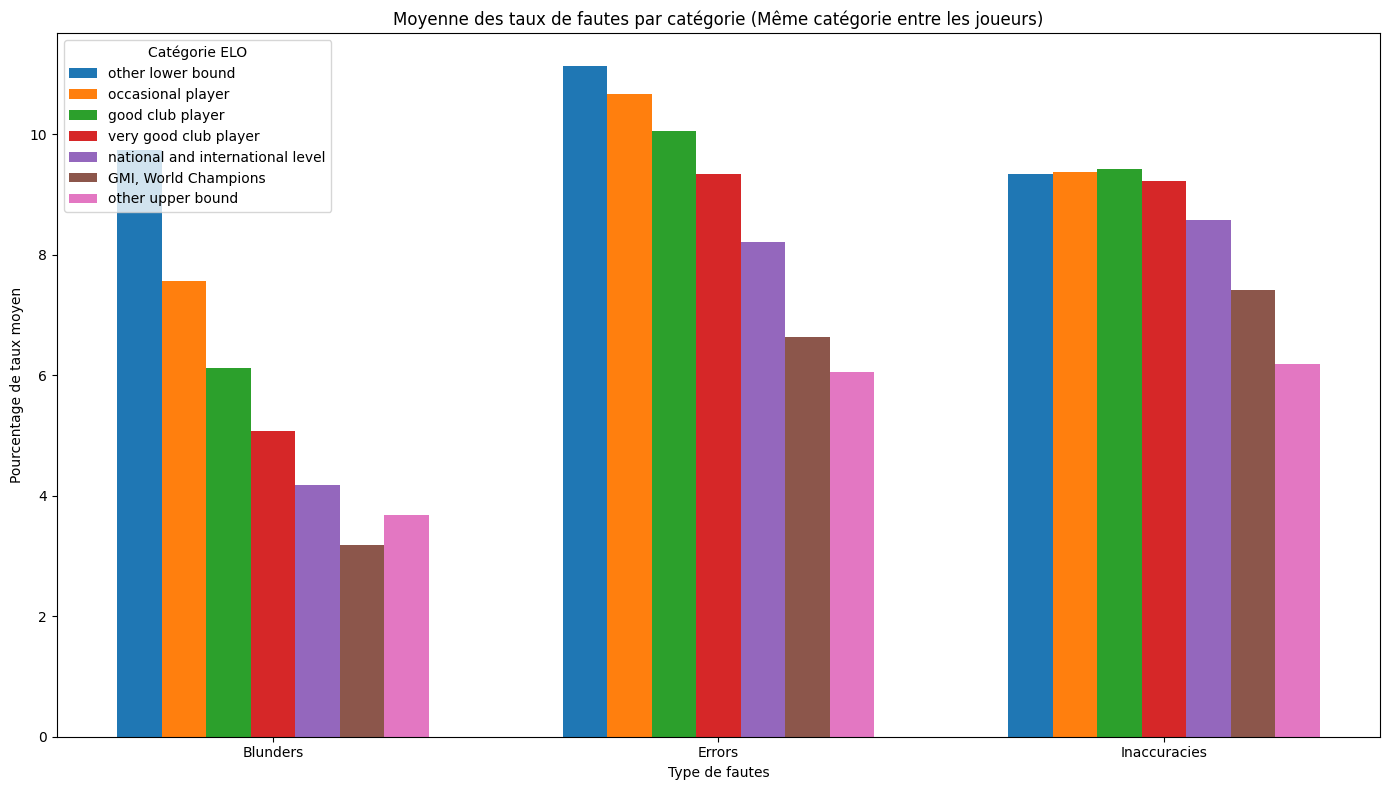

In [55]:
# Graphique
plt.figure(figsize=(14, 8))
x = np.arange(len(error_types))
bar_width = 0.1
for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=str(category))

plt.xlabel('Type de fautes')
plt.ylabel('Pourcentage de taux moyen')
plt.title('Moyenne des taux de fautes par catégorie (Même catégorie entre les joueurs)')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, error_types)
plt.legend(title="Catégorie ELO")
plt.tight_layout()
plt.show()

Pour ces parties, où les deux joueurs appartiennent à la même catégorie, **les observations sont similaires** à celles faites pour la moyenne des ELO des joueurs.

Cependant, pour la catégorie **"Other upper bound"**, on ne constate **pas de réaugmentation** des erreurs et inexactitudes, ce qui confirme que la moyenne des ELO des deux joueurs influençait les résultats dans cette catégorie.

En revanche, une légère réaugmentation des blunders est observée entre les catégories "National and International level" et "GMI, World Champions".

#### Résultats globaux

Nous observons des **résultats similaires** entre les parties où les catégories sont basées sur la moyenne des ELO des deux joueurs et celles où les deux joueurs appartiennent à la même catégorie ELO. Nous voyons, en effet, que tous **les taux de fautes ont tendance à diminuer** à mesure que la catégorie ELO augmente.

Ce résultat est en accord avec l'hypothèse initiale.

### Question 2

#### Q2: Win probability depending on opening:


**Hypothèse :** Les openings permettant aux blancs de gagner devrait être différents de ceux permettant aux noirs de gagner.

#####  **Q2a: With which opening does White have the best chance to win, by level category (*) and by type of game (Blitz, Fast, Classic).**

Nous avons constaté que certaines configurations n’étaient jouées que très rarement et aboutissaient systématiquement à une victoire des Blancs.  
Cela introduit un biais et ne permet pas d’identifier correctement quel opening offre réellement le plus de chances de gagner.  
En effet, plus de 3 800 configurations présentaient une White_win_probability égale à 1.

Nous avons donc décidé de conserver uniquement les configurations avec un nombre élevé de parties jouées afin d’obtenir des résultats plus pertinents.

Nous allons analyser les configurations possibles, c'est à dire les combinaisons de `Opening`, `White_ELO_category`, et `Game_type`.

In [56]:
# Calculer le nombre de parties pour chaque configuration
config_game_counts = df_spark_plus.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))
config_game_counts.orderBy("Total_games_count", ascending=False).show(5)

+--------------------+------------------+---------+-----------------+
|             Opening|White_ELO_category|Game_type|Total_games_count|
+--------------------+------------------+---------+-----------------+
|Queen's Pawn Game...| occasional player|    Blitz|            11963|
|Queen's Pawn Game...|  good club player|    Blitz|            11456|
|    Philidor Defense| occasional player|    Blitz|            10246|
|    Philidor Defense|  good club player|    Blitz|             9800|
|    Sicilian Defense|  good club player|    Blitz|             9702|
+--------------------+------------------+---------+-----------------+
only showing top 5 rows



In [57]:
# Nombre total de configurations uniques
print(f"Nombre total de configurations possibles : {config_game_counts.count()}")
print(f"Nombre de configurations possibles pour les différents types de jeux :")
config_game_counts.groupBy("Game_type").count().orderBy("count", ascending=False).show()

Nombre total de configurations possibles : 44438
Nombre de configurations possibles pour les différents types de jeux :
+--------------+-----+
|     Game_type|count|
+--------------+-----+
|         Blitz|12957|
|        Bullet|11401|
|         Rapid|10377|
|     Classical| 6892|
|Correspondence| 2811|
+--------------+-----+



In [58]:
# Nombre d'Opening par configurations
df_spark_plus.groupBy("White_ELO_category", "Game_type").count().orderBy("count", ascending=False).show(34)

+--------------------+--------------+------+
|  White_ELO_category|     Game_type| count|
+--------------------+--------------+------+
|    good club player|         Blitz|549747|
|   occasional player|         Blitz|450990|
|    good club player|         Rapid|350294|
|very good club pl...|         Blitz|287985|
|   occasional player|         Rapid|262582|
|national and inte...|         Blitz|254839|
|    good club player|        Bullet|245115|
|   other lower bound|         Blitz|243316|
|   occasional player|        Bullet|227062|
|very good club pl...|         Rapid|162121|
|   other lower bound|        Bullet|132848|
|very good club pl...|        Bullet|106572|
|   other lower bound|         Rapid| 95046|
|national and inte...|         Rapid| 94355|
|national and inte...|        Bullet| 81839|
|    good club player|     Classical| 63684|
|   occasional player|     Classical| 31710|
|very good club pl...|     Classical| 29430|
|GMI, World Champions|         Blitz| 24942|
|national 

Nous pouvons voir que le nombre de parties jouées par type de jeux n'est pas répartie de façon uniforme, et que certaines configurations sont très sous représentées.

In [59]:
# Filtrer les configurations avec plus de 100 parties jouées
# TODO : Voir si on adapte le nombre de parties (autre chose que 100)
filtered_configurations = config_game_counts.filter(col("Total_games_count") > 100)
filtered_configurations.orderBy("Total_games_count", ascending=False).show(5)
print(f"Nombre de configurations avec plus de 100 parties jouées : {filtered_configurations.count()}")

+--------------------+------------------+---------+-----------------+
|             Opening|White_ELO_category|Game_type|Total_games_count|
+--------------------+------------------+---------+-----------------+
|Queen's Pawn Game...| occasional player|    Blitz|            11963|
|Queen's Pawn Game...|  good club player|    Blitz|            11456|
|    Philidor Defense| occasional player|    Blitz|            10246|
|    Philidor Defense|  good club player|    Blitz|             9800|
|    Sicilian Defense|  good club player|    Blitz|             9702|
+--------------------+------------------+---------+-----------------+
only showing top 5 rows

Nombre de configurations avec plus de 100 parties jouées : 5955


In [60]:
filtered_df = df_spark_plus.join(filtered_configurations.select("Opening", "White_ELO_category", "Game_type"), on=["Opening", "White_ELO_category", "Game_type"], how="inner")

In [61]:
# Quels sont les différentes valeurs de Game_type ?
filtered_df.select("Game_type").distinct().show()

+--------------+
|     Game_type|
+--------------+
|        Bullet|
|         Blitz|
|     Classical|
|         Rapid|
|Correspondence|
+--------------+



L'énoncé précise "by type of game (Blitz, Fast, Classic)" mais on voit bien ici que c'est Blitz, Rapid et Classical.

In [62]:
# Comment sont explicités les différentes fin de partie ?
filtered_df.select("Result").distinct().show()

+-------+
| Result|
+-------+
|      *|
|1/2-1/2|
|    1-0|
|    0-1|
+-------+



1-0 : Victoire des blancs  
0-1 : Victoire des noirs  
1/2-1/2 : Match nul

In [63]:
# Récupération des parties voulues (blancs gagnes +  type de jeux Blitz, Fast, Classic)
df_white_wins = filtered_df.filter((col("Result") == "1-0") & (col("Game_type").isin(["Blitz", "Rapid", "Classical"])))
df_total_games = filtered_df.filter(col("Game_type").isin(["Blitz", "Rapid", "Classical"]))

In [64]:
# Pour chaque ouverture, catégorie et type de jeu on calcule le nombre de victoires des blancs
df_white_wins_groupby = df_white_wins.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("White_win_count"))

# Pareil mais on calcule le total de parties jouées
df_total_games_groupby = df_total_games.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))

In [65]:
df_white_wins_groupby.show(5)

+----------------+--------------------+---------+---------------+
|         Opening|  White_ELO_category|Game_type|White_win_count|
+----------------+--------------------+---------+---------------+
|Alekhine Defense|    good club player|    Blitz|            519|
|Alekhine Defense|    good club player|Classical|             68|
|Alekhine Defense|    good club player|    Rapid|            267|
|Alekhine Defense|national and inte...|    Blitz|            216|
|Alekhine Defense|national and inte...|    Rapid|             81|
+----------------+--------------------+---------+---------------+
only showing top 5 rows



In [66]:
df_total_games_groupby.show(5)

+----------------+--------------------+---------+-----------------+
|         Opening|  White_ELO_category|Game_type|Total_games_count|
+----------------+--------------------+---------+-----------------+
|Alekhine Defense|    good club player|    Blitz|             1010|
|Alekhine Defense|    good club player|Classical|              133|
|Alekhine Defense|    good club player|    Rapid|              514|
|Alekhine Defense|national and inte...|    Blitz|              424|
|Alekhine Defense|national and inte...|    Rapid|              141|
+----------------+--------------------+---------+-----------------+
only showing top 5 rows



In [67]:
# Calcule de la probabilité de gagner en fonction de l'ouverture
df_opening_stats = df_white_wins_groupby.join(df_total_games_groupby, on=["Opening", "White_ELO_category", "Game_type"])
df_opening_stats = df_opening_stats.withColumn("White_win_probability", col("White_win_count") / col("Total_games_count"))

In [68]:
df_opening_stats.show(5)

+----------------+--------------------+---------+---------------+-----------------+---------------------+
|         Opening|  White_ELO_category|Game_type|White_win_count|Total_games_count|White_win_probability|
+----------------+--------------------+---------+---------------+-----------------+---------------------+
|Alekhine Defense|    good club player|    Blitz|            519|             1010|   0.5138613861386139|
|Alekhine Defense|    good club player|Classical|             68|              133|   0.5112781954887218|
|Alekhine Defense|    good club player|    Rapid|            267|              514|    0.519455252918288|
|Alekhine Defense|national and inte...|    Blitz|            216|              424|   0.5094339622641509|
|Alekhine Defense|national and inte...|    Rapid|             81|              141|    0.574468085106383|
+----------------+--------------------+---------+---------------+-----------------+---------------------+
only showing top 5 rows



In [69]:
df_opening_stats.count()

4548

In [70]:
# Y a t il toutes les combinaisons de catégorie / type de partie ?
df_opening_stats.groupBy("White_ELO_category", "Game_type").count().orderBy("count", ascending=False).show(truncate=False)

+--------------------------------+---------+-----+
|White_ELO_category              |Game_type|count|
+--------------------------------+---------+-----+
|good club player                |Blitz    |680  |
|national and international level|Blitz    |549  |
|very good club player           |Blitz    |533  |
|occasional player               |Blitz    |519  |
|good club player                |Rapid    |494  |
|occasional player               |Rapid    |364  |
|very good club player           |Rapid    |342  |
|other lower bound               |Blitz    |332  |
|national and international level|Rapid    |237  |
|other lower bound               |Rapid    |185  |
|good club player                |Classical|149  |
|occasional player               |Classical|69   |
|very good club player           |Classical|46   |
|GMI, World Champions            |Blitz    |32   |
|other lower bound               |Classical|9    |
|national and international level|Classical|8    |
+------------------------------

In [71]:
# Je t'ai laissé ton TODO mais j'explique en dessous donc peut etre pas besoin qu'on se casse la tete
# TODO : faut puet etre qu'on regle autrement ou alors on commente sur le fait qu'on a pas Classical pour toutes les catégories etc

Nous pouvons voir que le nombre d'Opening différents (count) pour les combinaisons de catégories ELO et type de jeux n'est pas répartie uniformément, et certaines sont même absentes.

Cependant, dans le jeu de données initiale, ces configurations étaient très sous représentées. Notamment :
- GMI, World Champions - Rapid -  2163
- other upper bound - Blitz - 301
- GMI, World Champions - Classical - 232
- other upper bound - Rapid - 8
- other upper bound - Classical - 1

In [72]:
# Récupération du meilleur opening pour chaque catégorie de joueur et type de partie
window_spec = Window.partitionBy("White_ELO_category", "Game_type").orderBy(col("White_win_probability").desc())
best_openings = df_opening_stats.withColumn("rank", rank().over(window_spec))
best_openings = best_openings.filter(col("rank") == 1).select("White_ELO_category", "Game_type", "Opening", "White_win_probability")

###### Résultats

Nous affichons maintenant pour chaque catégorie ELO et type de jeu, l'opening permettant le plus de gagner pour les blancs.

In [73]:
best_openings.orderBy("White_ELO_category", "Game_type").show(17)

+--------------------+---------+--------------------+---------------------+
|  White_ELO_category|Game_type|             Opening|White_win_probability|
+--------------------+---------+--------------------+---------------------+
|GMI, World Champions|    Blitz|Slav Defense: Exc...|   0.6422764227642277|
|    good club player|    Blitz|Italian Game: Two...|   0.7928571428571428|
|    good club player|Classical|King's Pawn Game:...|   0.7448979591836735|
|    good club player|    Rapid|Modern Defense: M...|   0.7230769230769231|
|national and inte...|    Blitz|King's Pawn Game:...|    0.740506329113924|
|national and inte...|Classical|        Pirc Defense|   0.5897435897435898|
|national and inte...|    Rapid|Italian Game: Ant...|    0.740506329113924|
|   occasional player|    Blitz|King's Pawn Game:...|   0.6744868035190615|
|   occasional player|Classical|King's Pawn Game:...|     0.71900826446281|
|   occasional player|    Rapid|Queen's Gambit Ac...|   0.7368421052631579|
|   other lo

In [74]:
best_openings_pandas = best_openings.toPandas()

In [75]:
best_openings_pandas["GameType_Category"] = (best_openings_pandas["Game_type"] + " | " + best_openings_pandas["White_ELO_category"])

# Table pivot pour voir le meilleur opening pour chaque configuration
pivot_table = best_openings_pandas.pivot_table(
    index="GameType_Category",
    columns="Opening",
    values="White_win_probability"
)

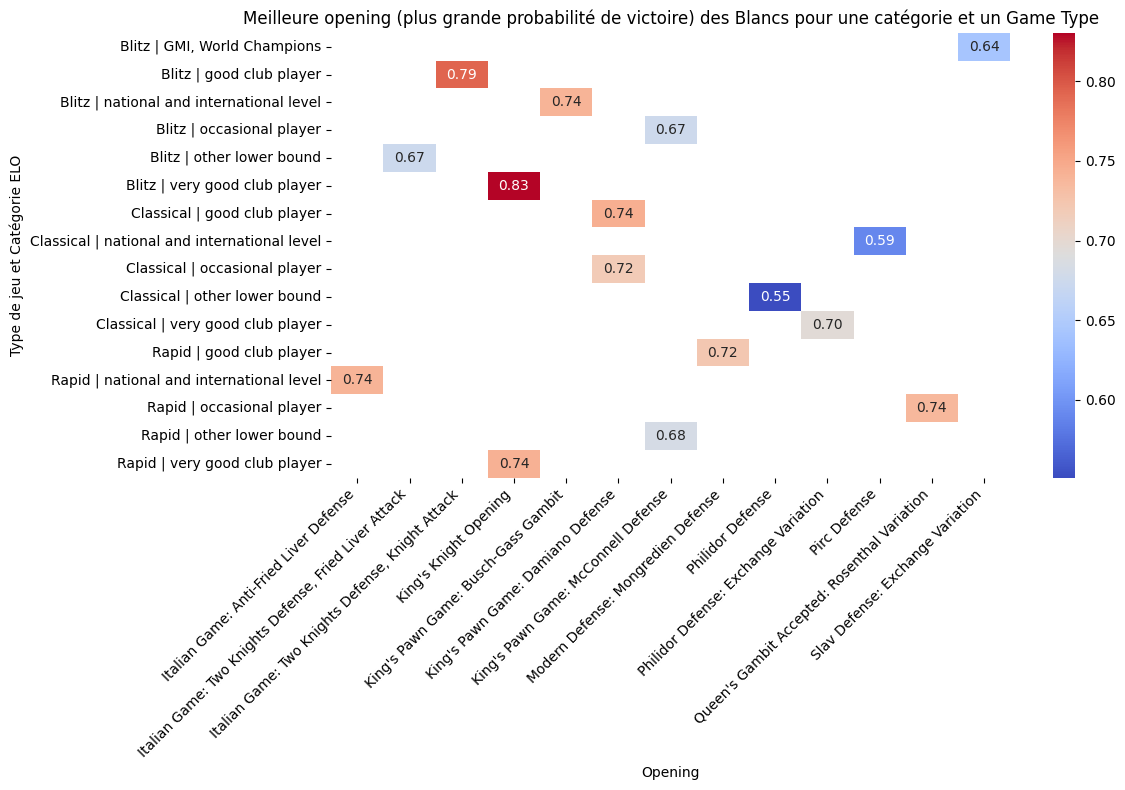

In [76]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Meilleure opening (plus grande probabilité de victoire) des Blancs pour une catégorie et un Game Type")
plt.xlabel("Opening")
plt.ylabel("Type de jeu et Catégorie ELO")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Nous pouvons voir que l'opening obtenant un meilleur résultat est généralement différent entre les configurations. Cela pourrait montrer qu'il y a un lien entre la victoire, le type de jeu, le niveau du joueur et l'opening choisi.

##### **Q2b: same question with black. You don't need to write again the same but only the results with black.**

In [77]:
# Calculer le nombre de parties pour chaque configuration
config_game_counts = df_spark_plus.groupBy("Opening", "Black_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))

In [78]:
# Filtrer les configurations avec plus de 100 parties jouées
# TODO : Voir si on adapte le nombre de parties (autre chose que 100)
filtered_configurations = config_game_counts.filter(col("Total_games_count") > 100)

In [79]:
filtered_df = df_spark_plus.join(filtered_configurations.select("Opening", "Black_ELO_category", "Game_type"), on=["Opening", "Black_ELO_category", "Game_type"], how="inner")

In [80]:
df_black_wins = filtered_df.filter((col("Result") == "0-1") & (col("Game_type").isin(["Blitz", "Rapid", "Classical"])))
df_total_games = filtered_df.filter(col("Game_type").isin(["Blitz", "Rapid", "Classical"]))

In [81]:
df_black_wins_groupby = df_black_wins.groupBy("Opening", "Black_ELO_category", "Game_type").agg(count("*").alias("Black_win_count"))
df_total_games_groupby = df_total_games.groupBy("Opening", "Black_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))

In [82]:
df_opening_stats = df_black_wins_groupby.join(df_total_games_groupby, on=["Opening", "Black_ELO_category", "Game_type"])
df_opening_stats = df_opening_stats.withColumn("Black_win_probability", col("Black_win_count") / col("Total_games_count"))

Nous affichons maintenant pour chaque catégorie ELO et type de jeu, l'opening (des blancs) permettant le plus de gagner pour les noirs.

In [83]:
window_spec = Window.partitionBy("Black_ELO_category", "Game_type").orderBy(col("Black_win_probability").desc())
best_openings = df_opening_stats.withColumn("rank", rank().over(window_spec))
best_openings = best_openings.filter(col("rank") == 1).select("Black_ELO_category", "Game_type", "Opening", "Black_win_probability") # Rank pour garder les égalités
best_openings.orderBy("Black_ELO_category", "Game_type").show(truncate=False)

+--------------------------------+---------+------------------------------------------------------------+---------------------+
|Black_ELO_category              |Game_type|Opening                                                     |Black_win_probability|
+--------------------------------+---------+------------------------------------------------------------+---------------------+
|GMI, World Champions            |Blitz    |Robatsch (Modern) Defense                                   |0.6190476190476191   |
|good club player                |Blitz    |Grünfeld Defense                                            |0.7099236641221374   |
|good club player                |Classical|King's Pawn Game: Napoleon Attack                           |0.6946564885496184   |
|good club player                |Rapid    |Paleface Attack                                             |0.7378640776699029   |
|national and international level|Blitz    |Caro-Kann Defense: Hillbilly Attack                         

In [84]:
best_openings_pandas = best_openings.toPandas()

In [85]:
best_openings_pandas["GameType_Category"] = (best_openings_pandas["Game_type"] + " | " + best_openings_pandas["Black_ELO_category"])
pivot_table = best_openings_pandas.pivot_table(
    index="GameType_Category",
    columns="Opening",
    values="Black_win_probability"
)

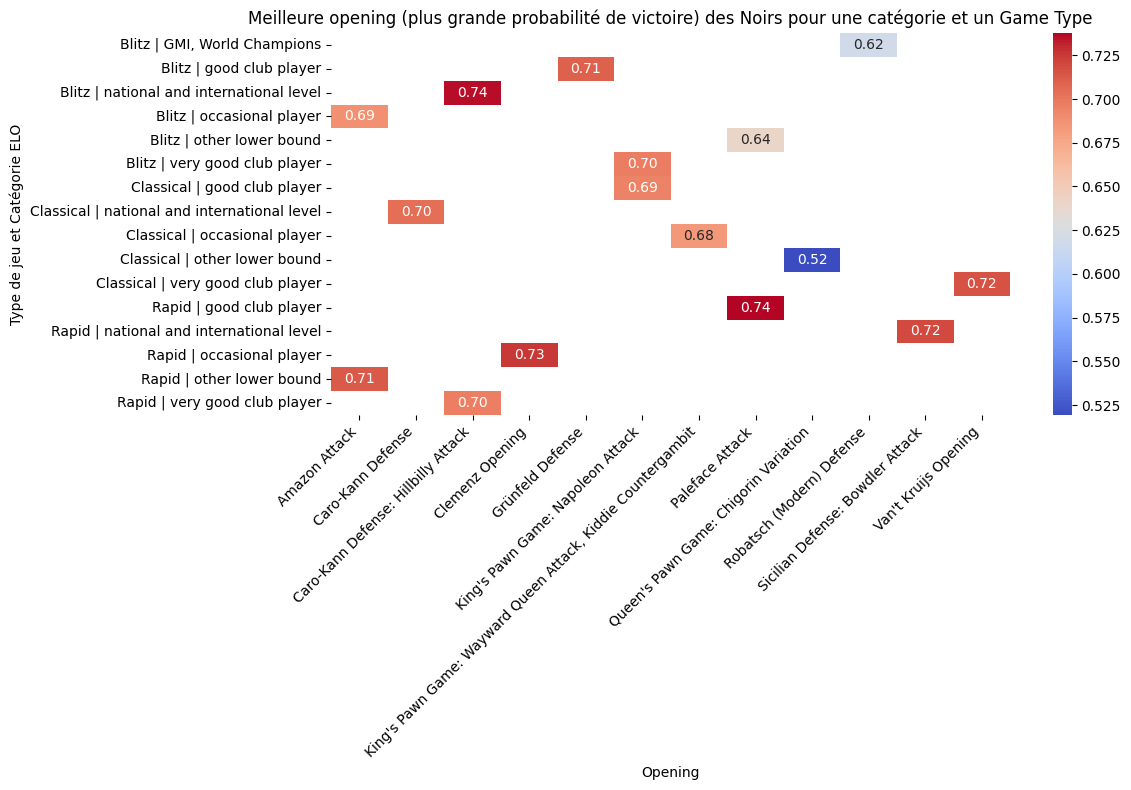

In [86]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Meilleure opening (plus grande probabilité de victoire) des Noirs pour une catégorie et un Game Type")
plt.xlabel("Opening")
plt.ylabel("Type de jeu et Catégorie ELO")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Nous pouvons voir que les openings permettant le plus aux noirs de gagner sont différents de ceux permettant aux blancs de gagner. De plus, nous voyons également que l'opening permettant le plus de gagner est différent selon les configurations.

In [87]:
# TODO : iuci faut peut etre dire que opening c'est le coup fait par le blanc (à moins que ce soit plusieurs enchainement s?)

In [88]:
# TODO : ici on peut regarder si on retrouve les memes choses entre noir et blanc*
# C'est différent lol #meilleurConclusionDeLannee

In [89]:
# TODO : Checker à quoi correspondent les openings permettant de gagner (agressif, ...)
# et voir s'il y a un lien entre ces types d'openings et les types de parties

### Question 3

In [140]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

*Q3: (difficult). Does a line of data in the file predict the outcome of the game (column Result), and with what
probability? In other words, can any of the variables, such as the number of errors (mistakes, blunders, inacurracies,
ts_blunders), the difference in ELO between the two players, etc., explain the outcome (win/loss)? You are free to
define explain as you wish. It can be a correlation, linear or not, or any other relationship that allows this prediction.  
Note that the ELO is itself computed from a probability (normal distribution) of victory depending on the difference
in ELO of the two players. For instance, for a difference of 100 ELO points, the higher ranked player is expected to
win with probability 0.64. For a 200 points difference, it is 0.76.  
As we have more data than the ELO difference, your prediction should be more accurate than that.*

TODO : Dire un résumé de ce qu'on fait dans cette partie

In [ ]:
# TODO zoe : mes idées pour cette partie c'est de faire :

# OK   préparer les données -> result à encoder
# différence de ELO blanc noir et / ou noir blanc
# on prend en compte blunders, mistakes, inaccuracies (la même avec les ts_)
# normaliser et encoder
# MLLIB -> vecteur
# train et test séparation
# construire modèle de régression (logistique ?) ou arbre (genre random forest ou xgboost ?)
# évaluer : MulticlassClassificationEvaluator
# interpréter : Comparez la performance du modèle à celle prédite uniquement par la différence d'ELO (probabilités théoriques).
# analyse les coefficients (dans le cas de la régression logistique) : importance de chaque variable.


# en fait ils veulent qu'on explique... y a pas moyen de faire un truc avec explicabilité ?

#### Préparation des données

In [175]:
df_spark_plus.show(5)

+----+--------+---------------+----------+---+----------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+--------------------+--------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+--------------------+-----------+-----------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|           Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|  Black_ELO_category|  White_ELO_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccu

##### **Suppression des colonnes non nécessaires**

Nous allons supprimer certaines colonnes du jeu de données qui ne sont pas pertinentes pour la prédiction de la colonne `Result` et/ou qui pourrait introduire un biais.

<ins>Suppression des colonnes étant des conséquences du résultat:</ins>
* `BlackRatingDiff` :  Variation du classement ELO du joueur noir après la partie
* `WhiteRatingDiff` : Variation du classement ELO du joueur blanc après la partie

Ces colonnes reflètent directement l'issue de la partie et ne peuvent donc pas être utilisées comme des variables explicatives pour prédire le résultat.

<ins>Suppression des colonnes n'apportant pas d'informations pertinentes :</ins>
* `GAME` : Identifiant unique de la partie
* `Date`: Date à laquelle la partie a été jouée
* `Site`: URL de la partie
* `starting_time` : Temps initial disponible pour chaque joueur
* `increment` : Temps ajouté après chaque coup
* `TimeControl` : Temps de jeu en secondes (temps initial + incrément)
* `UTCTime` : Heure à laquelle la partie a été jouée
* `Event` : Evenement où la partie a été jouée

<ins>Suppression des colonnes redondantes :</ins>
* `BlackElo` : Classement ELO du joueur avec les pièces noires
* `WhiteElo` : Classement ELO du joueur avec les pièces blanches

Ces colonnes ont été utilisées pour calculer les colonnes `Black_ELO_category` et `White_ELO_category`, elles ne sont pas nécessaire car l'information est déjà présente.

* `Avg_ELO_category` : Catégorie moyenne des 2 joueurs

Cette colonne n'apporte pas non plus d'informations supplémentaires.

In [176]:
# TODO : Garder ELO plutot que categorie car dans l'énoncé c'est dit qu'une différence de 100
# permet de savoir assez bien qui gagne et on a plus cette infos dans nos catégories

In [192]:
# Suppression des colonnes
df_preparation = df_spark_plus.drop("BlackRatingDiff", "WhiteRatingDiff", "GAME", "Date", "Site", "starting_time", "increment", "TimeControl", "UTCTime", "Event", "BlackElo", "WhiteElo", "Avg_ELO_category")

In [178]:
df_preparation.show(5)

+---+--------------------+------+------------+--------------------+--------------------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+-----------+-----------+
|ECO|             Opening|Result| Termination|  Black_ELO_category|  White_ELO_category|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Black_long_moves|White_long_moves|Black_bad_long_moves|White_bad_long_moves|Game_flips|Game_flips_ts|white_moves|black_moves|
+---+--------------------+------+------------+

##### **Encodage des colonnes non numériques**

In [179]:
# Observation des types des colonnes pour savoir comment les traiter
schema = df_preparation.schema
columns_by_type = defaultdict(list)

for field in schema:
    columns_by_type[str(field.dataType)].append(field.name)

for data_type, columns in columns_by_type.items():
    print(f"Type: {data_type}")
    print(f"Columns: {columns}\n")

Type: StringType()
Columns: ['ECO', 'Opening', 'Result', 'Termination', 'Black_ELO_category', 'White_ELO_category', 'Game_type']

Type: IntegerType()
Columns: ['Total_moves', 'Black_blunders', 'White_blunders', 'Black_mistakes', 'White_mistakes', 'Black_inaccuracies', 'White_inaccuracies', 'Black_inferior_moves', 'White_inferior_moves', 'Black_ts_moves', 'White_ts_moves', 'Black_ts_blunders', 'White_ts_blunders', 'Black_ts_mistakes', 'White_ts_mistake', 'Black_long_moves', 'White_long_moves', 'Black_bad_long_moves', 'White_bad_long_moves', 'Game_flips', 'Game_flips_ts']

Type: DoubleType()
Columns: ['white_moves', 'black_moves']



Il y a 7 colonnes de type chaine de caractères, nous allons les encoder afin de pouvoir les utiliser dans nos prédictions.

In [187]:
# Afficher les valeurs pour les colonnes non numériques
columns_to_check = [
    'ECO', 'Opening', 'Result', 'Termination', 'Black_ELO_category', 'White_ELO_category', 'Game_type'
]

for column in columns_to_check:
    print(f"Valeurs possibles pour la colonne '{column}':")
    df_preparation.select(column).distinct().show(truncate=False)


Valeurs possibles pour la colonne 'ECO':
+---+
|ECO|
+---+
|B05|
|A23|
|E02|
|B79|
|B34|
|E83|
|A47|
|D81|
|E44|
|A76|
|B01|
|C22|
|A65|
|E56|
|B92|
|A46|
|C78|
|C95|
|C24|
|C77|
+---+
only showing top 20 rows

Valeurs possibles pour la colonne 'Opening':
+-------------------------------------------------------------------------------------+
|Opening                                                                              |
+-------------------------------------------------------------------------------------+
|Grünfeld Defense: Exchange Variation                                                 |
|Four Knights Game: Spanish Variation, Rubinstein Variation Accepted                  |
|Ruy Lopez: Berlin Defense, Tarrasch Trap                                             |
|King's Gambit, Falkbeer Countergambit, Blackburne Attack                             |
|King's Indian Attack: Wahls Defense                                                  |
|Alekhine Defense: Modern Variation, Lar

Nous allons gérer ces colonnes de façons différentes, en fonction de leur nombre de valeurs possibles et de leur type.

* `Result` : Colonne à prédire
* `ECO`, `Opening` : Beaucoup de valeurs possibles
* `Termination`, `Black_ELO_category`, `White_ELO_category`, `Game_type` : Peu de valeurs


In [181]:
# Nombre de valeurs par Result
df_preparation.groupBy("Result").count().show()

+-------+-------+
| Result|  count|
+-------+-------+
|      *|     72|
|1/2-1/2| 109548|
|    1-0|1863894|
|    0-1|1766395|
+-------+-------+



Il y a seulement 72 valeurs indéfini dans la colonnes Result, nous allons supprimer ces parties, car elles n'ont pas d'intérêts et sont en trop faible nombre pour apporter un réel résultat à notre analyse.

In [193]:
df_preparation = df_preparation.filter(col("Result") != "*")

In [194]:
# Encodage des colonnes non numériques
# Colonne cible
df_preparation = df_preparation.withColumn(
    "Result_encoded",
    when(col("Result") == "1-0", 2)
    .when(col("Result") == "0-1", 1)
    .when(col("Result") == "1/2-1/2", 0)
    .otherwise(None)
)

# Colonnes avec beaucoup de valeurs
indexer_eco = StringIndexer(inputCol="ECO", outputCol="ECO_index")
indexer_opening = StringIndexer(inputCol="Opening", outputCol="Opening_index")
df_preparation = indexer_eco.fit(df_preparation).transform(df_preparation)
df_preparation = indexer_opening.fit(df_preparation).transform(df_preparation)

# Colonnes avec peu de valeurs
columns_to_encode = ['Termination', 'Black_ELO_category', 'White_ELO_category', 'Game_type']
for column in columns_to_encode:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    encoder = OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_ohe")
    df_preparation = indexer.fit(df_preparation).transform(df_preparation)
    df_preparation = encoder.fit(df_preparation).transform(df_preparation)

##### **Normalisation des données**

In [195]:
# Normalisation des colonnes numériques
numeric_cols = [
    'Total_moves', 'Black_blunders', 'White_blunders', 'Black_mistakes', 'White_mistakes',
    'Black_inaccuracies', 'White_inaccuracies', 'Black_inferior_moves', 'White_inferior_moves',
    'Black_ts_moves', 'White_ts_moves', 'Black_ts_blunders', 'White_ts_blunders',
    'Black_ts_mistakes', 'White_ts_mistake', 'Black_long_moves', 'White_long_moves',
    'Black_bad_long_moves', 'White_bad_long_moves', 'Game_flips', 'Game_flips_ts',
    'white_moves', 'black_moves'
]

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_raw")
df_prepared = assembler.transform(df_preparation)

scaler = MinMaxScaler(inputCol="features_raw", outputCol="scaled_features")
scaler_model = scaler.fit(df_prepared)
df_prepared = scaler_model.transform(df_prepared)

In [196]:
# Combinaison des colonnes finales
feature_cols = ['scaled_features', 'ECO_index', 'Opening_index'] + [f"{col}_ohe" for col in columns_to_encode]
final_assembler = VectorAssembler(inputCols=feature_cols, outputCol="final_features")
df_prepared = final_assembler.transform(df_prepared)

# Suppression des colonnes inutiles
cols_to_drop = ['ECO', 'Opening', 'Result', 'Termination', 'Black_ELO_category', 'White_ELO_category', 'Game_type',
                'features_raw', 'scaled_features'] + numeric_cols
df_prepared = df_prepared.drop(*cols_to_drop)

In [197]:
df_prepared.show(5)

+--------------+---------+-------------+-----------------+---------------+------------------------+----------------------+------------------------+----------------------+---------------+-------------+--------------------+
|Result_encoded|ECO_index|Opening_index|Termination_index|Termination_ohe|Black_ELO_category_index|Black_ELO_category_ohe|White_ELO_category_index|White_ELO_category_ohe|Game_type_index|Game_type_ohe|      final_features|
+--------------+---------+-------------+-----------------+---------------+------------------------+----------------------+------------------------+----------------------+---------------+-------------+--------------------+
|             1|     57.0|         60.0|              1.0|  (3,[1],[1.0])|                     3.0|         (6,[3],[1.0])|                     3.0|         (6,[3],[1.0])|            0.0|(4,[0],[1.0])|(44,[0,1,2,4,5,6,...|
|             1|     16.0|         80.0|              0.0|  (3,[0],[1.0])|                     0.0|         (6,[

#### Regression logistique

In [229]:
# TODO : revoir Réduction dataset car modele trop long

In [232]:
# Séparation train et test
train_data, test_data = df_sampled.randomSplit([0.8, 0.2], seed=42)

In [233]:
# Modèle
lr = LogisticRegression(featuresCol="final_features", labelCol="Result_encoded", maxIter=3, regParam=0.0)

In [235]:
# Entrainement
lr_model = lr.fit(train_data)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# TODO : Pas fais en dessous, le modele met trop de temps à s'entrainer

# Prédictions sur données test
predictions = lr_model.transform(test_data)

In [ ]:
# Evaluation
evaluator = MulticlassClassificationEvaluator(
    labelCol="Result_encoded",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Précision du modèle : {accuracy:.2f}")

In [ ]:
# Résultats de prédiction
predictions.select("Result_encoded", "prediction", "probability").show(10, truncate=False)

# Analyse des coefficients
print("Coefficients du modèle :")
for coef, col_name in zip(lr_model.coefficients.toArray(), df_prepared.columns[:-1]):
    print(f"{col_name}: {coef}")

print(f"Intercept : {lr_model.intercept}")

#### Brouillon Q3

In [149]:
# Encodage des colonnes non-numériques

# Beaucoup de valeurs : ECO et Opening
# ==> StringIndexer
indexer_eco = StringIndexer(inputCol="ECO", outputCol="ECO_index")
indexer_opening = StringIndexer(inputCol="Opening", outputCol="Opening_index")

df_preparation = indexer_eco.fit(df_preparation).transform(df_preparation)
df_preparation = indexer_opening.fit(df_preparation).transform(df_preparation)

# Peu de valeurs : Termination, Black_elo_category, White_elo_category, Game_type, Event_type
# ==> StringIndexer et OneHotEncoder
columns_to_encode = ['Termination', 'Black_ELO_category', 'White_ELO_category', 'Game_type']

for column in columns_to_encode:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    encoder = OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_ohe")

    # Appliquer StringIndexer et OneHotEncoder
    df_preparation = indexer.fit(df_preparation).transform(df_preparation)
    df_preparation = encoder.fit(df_preparation).transform(df_preparation)

# Colonne à prédire : Result
# ==> Encodage numérique
df_preparation = df_preparation.withColumn(
    "Result_encoded",
    when(col("Result") == "1-0", 1)
    .when(col("Result") == "0-1", 0)
    .when(col("Result") == "1/2-1/2", -1)
    .otherwise(None) # TODO le * on en fait quoi ?
)

In [150]:
# Supprimer colonnes string remplacées si dessus
df_preparation = df_preparation.drop('ECO', 'Opening','Termination', 'Black_ELO_category', 'White_ELO_category', 'Game_type', 'Result')

In [151]:
df_preparation.printSchema()

root
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistakes: integer (nullable = true)
 |-- Black_inaccuracies: integer (nullable = true)
 |-- White_inaccuracies: integer (nullable = true)
 |-- Black_inferior_moves: integer (nullable = true)
 |-- White_inferior_moves: integer (nullable = true)
 |-- Black_ts_moves: integer (nullable = true)
 |-- White_ts_moves: integer (nullable = true)
 |-- Black_ts_blunders: integer (nullable = true)
 |-- White_ts_blunders: integer (nullable = true)
 |-- Black_ts_mistakes: integer (nullable = true)
 |-- White_ts_mistake: integer (nullable = true)
 |-- Black_long_moves: integer (nullable = true)
 |-- White_long_moves: integer (nullable = true)
 |-- Black_bad_long_moves: integer (nullable = true)
 |-- White_bad_long_moves: integer (nullable = true)
 |-- Game_flips: integer (nullable = true)
 |-- Game_flips

In [152]:
df_preparation.show(5)

+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+-----------+-----------+---------+-------------+-----------------+---------------+------------------------+----------------------+------------------------+----------------------+---------------+-------------+--------------+
|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Black_long_moves|White_long_moves|Black_bad_long_moves|White_bad_long_moves|Game_flips|Game_flips_ts|white_moves|black_moves|ECO_index|Opening_index|Termination_index|

##### **Normalisation des données**

In [131]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

In [ ]:
# TODO : Peut etre revoir je suis pas sure, faut normaliser en vecteurs en Spark lol (envie de crever)

In [155]:
numeric_cols = [col_name for col_name, dtype in df_preparation.dtypes if dtype in ('int', 'double') and col_name != 'Result_encoded' and "_index" not in col_name]

# Assemblage dans un vecteur des colonnes numériques
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_with_features = assembler.transform(df_preparation)

# Normalisation
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_with_features)
df_normalized = scaler_model.transform(df_with_features)

In [156]:
# Vérification
df_normalized.select("features", "scaled_features").show(5)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[66.0,4.0,2.0,0.0...|[0.18465909090909...|
|(23,[0,1,2,3,4,5,...|(23,[0,1,2,3,4,5,...|
|[70.0,0.0,1.0,1.0...|[0.19602272727272...|
|[86.0,4.0,2.0,1.0...|[0.24147727272727...|
|(23,[0,1,3,4,5,6,...|(23,[0,1,3,4,5,6,...|
+--------------------+--------------------+
only showing top 5 rows



In [169]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

# Convertir le vecteur "scaled_features" en colonnes individuelles
df_final = df_normalized.withColumn("scaled_array", vector_to_array(col("scaled_features")))

# Réattribuer les colonnes normalisées
for i, column in enumerate(numeric_cols):
    df_final = df_final.withColumn(f"scaled_{column}", col("scaled_array")[i])

# Afficher les données finalisées
df_final.show(5)


+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+-----------+-----------+---------+-------------+-----------------+---------------+------------------------+----------------------+------------------------+----------------------+---------------+-------------+--------------+--------------------+--------------------+--------------------+-------------------+---------------------+---------------------+---------------------+---------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------+---------------------+------------------------+------------------------+------------------------+-----------------------+

In [170]:
# drop numeric_cols
df_final = df_final.drop(*numeric_cols, "features", "scaled_features", "scaled_array")

In [171]:
# Afficher les données finalisées
df_final.show(5)

+---------+-------------+-----------------+---------------+------------------------+----------------------+------------------------+----------------------+---------------+-------------+--------------+-------------------+---------------------+---------------------+---------------------+---------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------+---------------------+------------------------+------------------------+------------------------+-----------------------+-----------------------+-----------------------+---------------------------+---------------------------+--------------------+--------------------+-------------------+-------------------+
|ECO_index|Opening_index|Termination_index|Termination_ohe|Black_ELO_category_index|Black_ELO_category_ohe|White_ELO_category_index|White_ELO_category_ohe|Game_type_index|Game_type_ohe|Result_encoded| scaled_Total_moves|scaled_Black_blunders|scaled_White

In [ ]:
# TODO : Je comprend rien on va voir plus tard si ca a marché lol
# Ajouter les colonnes OneHot mais je sais pas comment

### Questions supplémentaires

## Idées questions supplémentaires

- influence of time spent per move on errors
  - existe t il une corrélation entre le temps moyen par coup et le nombre d'erreurs ?
  - analyse par niveau et type de jeu

- distribtion of drawn games by opening and level
  - quelles ouvertures ont une probabilité plus élevée de conduire à une partie nulle ?
  - analyse des taux de parties nulles en fonciton de l'ouverture et des catégories ELO

- impact of ELO difference on game length
  - les parties avec une grande différence d'ELO durent-elles moins longtemps (en nombre de coups) ?

- most common mistakes by level
  - quels types d'erreurs sont les plus fréquents selon les catégories ELO ?
  - comparaison entre joueurs de niveau débutant et expert

- optimal strategy for specific openings
  - pour une ouverture donnée (à sélectionner manuellement), quelle est la stratégie optiale selon le niveau des joueurs ?